# Image compression with K-means

- **Original Image Representation:**  In a typical 24-bit color image, each pixel's color is made from three 8-bit values representing red, green, and blue (RGB) intensity. Since each 8-bit value can range from 0 to 255, there are $256 \times 256 \times 256 = 16,777,216$ possible colors.
<br>

- **Goal:** We want to reduce the image's color palette to only 16 colors. By doing this, we can compress the image and represent it more efficiently.
<br>

- **How We'll Do it:** Instead of using 24 bits for each pixel (8 bits for each RGB channel), we'll use only 4 bits per pixel. Since $2^4 = 16$, we can represent 16 different color indices with 4 bits.
<br>

- **Using K-means Algorithm:** We'll apply the K-means algorithm to our image's pixels, treating them as points in a 3-dimensional RGB space. The goal is to find 16 cluster centers, which will become our new 16 colors.
    - **Initialization:** Select 16 initial colors (centroids).
    - **Assignment Step:** Assign each pixel to the nearest centroid in the RGB space.
    - **Update Step:** Recalculate the centroids as the mean of all pixels assigned to them.
    - **Repeat:** Repeat steps 2 and 3 until the centroids no longer change significantly.
<br><br>

- **After Finding the 16 Colors:** For each pixel in the original image, we'll replace its color with the nearest one from our 16 selected colors.
<br>

- **Result:** We've compressed the image by representing it with only 16 colors. Now, we only need to store the RGB values of these 16 colors and a 4-bit index for each pixel, dramatically reducing the file size.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from kmeans import kmeans_random_init, compute_centroids, find_closest_centroids, run_kmeans
from utils import *

## Load Image

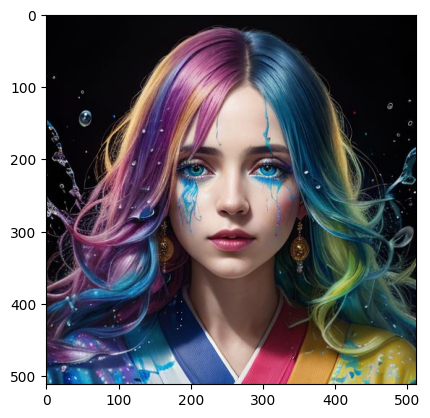

In [11]:
original_img = plt.imread('images/colorful.png')
plt.imshow(original_img)

In [12]:
print("Shape of original_img is:", original_img.shape)

Shape of original_img is: (512, 512, 3)


* the first two indices identify a pixel position, and
* the third index represents red, green, or blue. 

For example, `original_img[50, 33, 2]` gives the blue intensity of the pixel at row 50 and column 33.

## Process Image Data

To call `run_kmeans`, we need to first transform the matrix `original_img` into a two-dimensional matrix.

* The code below reshapes the matrix `original_img` to create an $m \times 3$ matrix of pixel colors (where
$m=262144 = 512\times512$)

*Note: To try this exercise on a JPG file, we first need to divide the pixel values by 255 so it will be in the range 0 to 1. This is not necessary for PNG files because it is already loaded in the required range (as mentioned in the [plt.imread() documentation](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imread.html)).*

In [13]:
X_img = np.reshape(original_img, (original_img.shape[0] * original_img.shape[1], 3))

In [14]:
print("Shape of reshaped image is:", X_img.shape)

Shape of reshaped image is: (262144, 3)


## Run K-Means on Image Pixels
Below, we run K-Means on the pre-processed image.

In [15]:
# Number of clusters
K = 16

# Randomly initialize k-means with K = 16
initial_centroids = kmeans_random_init(X_img, K)

# Run K-Means
centroids, idx = run_kmeans(X_img, initial_centroids, max_iters=10)

Iteration 1/10...
Iteration 2/10...
Iteration 3/10...
Iteration 4/10...
Iteration 5/10...
Iteration 6/10...
Iteration 7/10...
Iteration 8/10...
Iteration 9/10...
Iteration 10/10...


In [16]:
print("Shape of idx:", idx.shape)

Shape of idx: (262144,)


The code below will plot all the colors found in the original image. As mentioned earlier, the color of each pixel is represented by RGB values so the plot should have 3 axes -- R, G, and B. Notice a lot of dots below representing thousands of colors in the original image. The red markers represent the centroids after running K-means. These will be the 16 colors that we will use to compress the image.

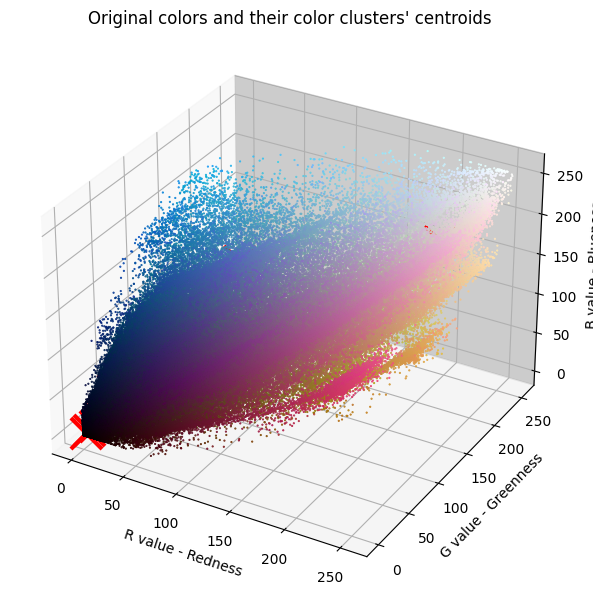

In [17]:
# Plot the colors of the image and mark the centroids
plot_kMeans_RGB(X_img, centroids, idx, K)

We can visualize the colors at each of the red markers (i.e. the centroids) above with the function below. We will only see these colors when we generate the new compressed image.

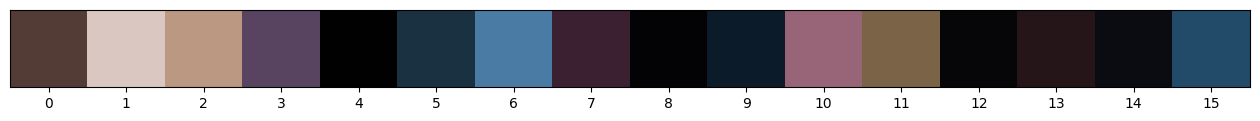

In [18]:
# Visualize the 16 colors selected
show_centroid_colors(centroids)

## Compress the Image
After finding the top $K=16$ colors to represent the image, we can now assign each pixel position to its closest centroid using the `find_closest_centroids` function. 
* This allows us to represent the original image using the centroid assignments of each pixel. 
* Notice that we have significantly reduced the number of bits that are required to describe the image. 
    * The original image required 24 bits (i.e. 8 bits x 3 channels in RGB encoding) for each one of the $512\times512$ pixel locations, resulting in total size of $512 \times 512 \times 24 = 6,291,456$ bits. 
    * The new representation requires some overhead storage in form of a dictionary of 16 colors, each of which require 24 bits, but the image itself then only requires 4 bits per pixel location. 
    * The final number of bits used is therefore $(16 \times 24) + (512 \times 512 \times 4) = 1,048,960$ bits, which corresponds to compressing the original image by about a factor of 6.

In [19]:
# Find the closest centroid of each pixel
idx = find_closest_centroids(X_img, centroids)

# Replace each pixel with the color of the closest centroid
X_compressed = centroids[idx, :]

# Reshape image into proper dimensions
X_compressed = np.reshape(X_compressed, original_img.shape)

## Compressed Image Result

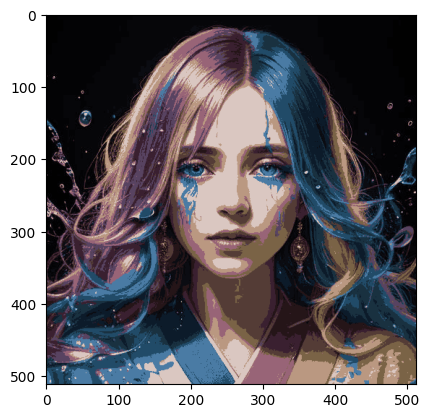

In [20]:
plt.imshow(X_compressed)

## Comparison

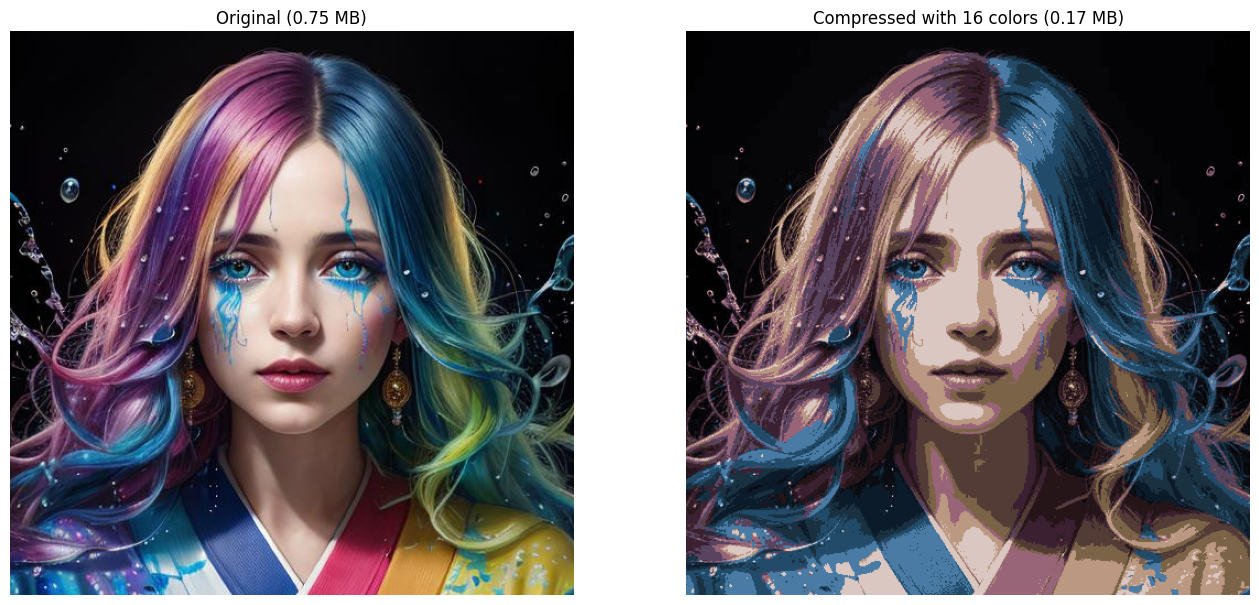

In [21]:
width, height = 512, 512

original_img_size = (width * height * 24) / 8 / 1024 / 1024
compressed_img_size = (width * height * (4 + 24/16)) / 8 / 1024 / 1024

fig, ax = plt.subplots(1,2, figsize=(16,16))

# Display original image
ax[0].imshow(original_img)
ax[0].set_title('Original (%.2f MB)' % original_img_size)
ax[0].set_axis_off()

# Display compressed image
ax[1].imshow(X_compressed)
ax[1].set_title('Compressed with %d colors (%.2f MB)' % (K, compressed_img_size))
ax[1].set_axis_off()

plt.show()